# Actividad: Intervalos de Confianza para Proporciones
Esta libreta aborda tres ejercicios de intervalos de confianza para proporciones muestrales dentro del contexto de inferencia estadística.

## Configuración del entorno
Importamos las bibliotecas clave y dejamos listas funciones auxiliares para reutilizar en cada problema.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, beta
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import samplesize_confint_proportion # Importamos esta función

plt.style.use('seaborn-v0_8-whitegrid')

def intervalo_proporcion_normal(x: int, n: int, confidence: float) -> dict:
    """Calcula intervalo de confianza normal aproximado para una proporción."""
    p_hat = x / n                         # estimador puntual de la proporción donde x es el número de éxitos y n el tamaño de la muestra
    alpha = 1 - confidence                # nivel de significancia
    z = norm.ppf(1 - alpha / 2)           # valor crítico z
    se = np.sqrt(p_hat * (1 - p_hat) / n) # error estándar
    error = z * se                        # error máximo
    return {
        "p_hat": p_hat,                   # estimador puntual
        "z": z,                           # valor crítico z
        "se": se,                         # error estándar
        "lower": max(0.0, p_hat - error), # límite inferior
        "upper": min(1.0, p_hat + error), # límite superior
        "error": error,                   # error máximo
        "confidence": confidence,         # nivel de confianza
        "n": n,                           # tamaño de la muestra
        "x": x                            # número de éxitos
    }

def intervalo_proporcion_clopper_pearson(x: int, n: int, confidence: float) -> tuple[float, float]:
    """Intervalo exacto (Clopper-Pearson) útil como referencia para muestras pequeñas."""
    alpha = 1 - confidence                                          # nivel de significancia
    lower = beta.ppf(alpha / 2, x, n - x + 1) if x > 0 else 0.0     # límite inferior donde x es el número de éxitos y n el tamaño de la muestra
    upper = beta.ppf(1 - alpha / 2, x + 1, n - x) if x < n else 1.0 # límite superior
    return lower, upper

def resumen_intervalo(nombre: str, resultado: dict, intervalo_exacta: tuple[float, float] | None = None) -> pd.DataFrame:
    """Arma un resumen tabular para reportar un intervalo de confianza."""
    data = {
        "escenario": [nombre],                                    # nombre del escenario
        "muestra (x/n)": [f"{resultado['x']}/{resultado['n']}"],  # tamaño de la muestra
        "p_con_hat": [resultado["p_hat"]],                        # estimador puntual
        "nivel_confianza": [resultado["confidence"]],             # nivel de confianza
        "limite_inferior": [resultado["lower"]],                  # límite inferior
        "limite_superior": [resultado["upper"]],                  # límite superior
        "error_maximo": [resultado["error"]]                      # error máximo
    }
    df = pd.DataFrame(data)
    if intervalo_exacta is not None:
        df["cp_inferior"], df["cp_superior"] = intervalo_exacta
    return df

## Problema 1: Parámetros y verificación de supuestos

Se hizo una encuesta a 325 personas mayores de 16 años y se encontró que 120 iban al teatro regularmente. Hallar, con un nivel de confianza del 94%, un intervalo para estudiar la proporción de los ciudadanos que van al teatro regularmente.

Trabajamos con la proporción de ciudadanos que van al teatro regularmente. Se documentan los valores observados y se valida la condición de normalidad aproximada.

In [4]:
# Definimos el tamaño de la muestra, el número de éxitos y el nivel de confianza
n1 = 325         # tamaño de la muestra
x1 = 120         # número de personas que van al teatro regularmente
conf1 = 0.94     # nivel de confianza (94%)

# Calculamos la proporcion muestral
p_hat1 = x1/ n1

npq1 = n1 * p_hat1 * (1- p_hat1)
condicion_normal_1 = npq1 >= 10

res1 = intervalo_proporcion_normal(x1, n1, conf1)

cp1 = intervalo_proporcion_clopper_pearson(x1, n1, conf1)

parametros = pd.DataFrame({
    'parametros': ['n', 'x', 'p_hat', 'n*p_hat*(1-p_hat)', 'condicion_normal'],
    'valor':[n1, x1, p_hat1, npq1, condicion_normal_1]
})

parametros

,parametros,valor
0,n,325
1,x,120
2,p_hat,0.369231
3,n*p_hat*(1-p_hat),75.692308
4,condicion_normal,True


## Problema 1: Cálculo e interpretación del intervalo
Se determina el intervalo de confianza para la proporción de asistencia al teatro e incluimos una visualización de la estimación puntual y sus márgenes.

/tmp/ipython-input-3793167289.py:13: UserWarning: Glyph 770 (\N{COMBINING CIRCUMFLEX ACCENT}) missing from font(s) Liberation Sans.
  plt.tight_layout()


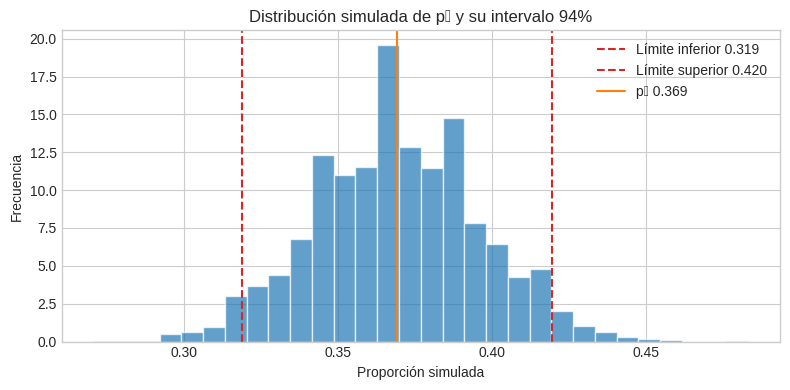

,escenario,muestra (x/n),p_con_hat,nivel_confianza,limite_inferior,limite_superior,error_maximo,cp_inferior,cp_superior
0,Teatro (94%),120/325,0.369231,0.94,0.318883,0.419579,0.050348,0.318646,0.422057


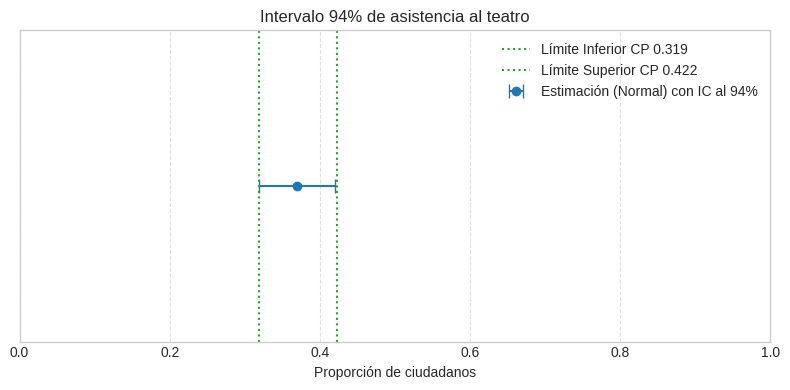

In [25]:
num_simulaciones = 10000
simulaciones = np.random.binomial(n1, res1["p_hat"], size=num_simulaciones) / n1

fig1, ax1 = plt.subplots(figsize=(8, 4))
ax1.hist(simulaciones, bins=30, color="tab:blue", alpha=0.7, edgecolor="white", density=True)
ax1.axvline(res1["lower"], color="tab:red", linestyle="--", label=f"Límite inferior {res1['lower']:.3f}")
ax1.axvline(res1["upper"], color="tab:red", linestyle="--", label=f"Límite superior {res1['upper']:.3f}")
ax1.axvline(res1["p_hat"], color="tab:orange", linestyle="-", label=f"p̂ {res1['p_hat']:.3f}")
ax1.set_title(f"Distribución simulada de p̂ y su intervalo {int(res1['confidence']*100)}%")
ax1.set_xlabel("Proporción simulada")
ax1.set_ylabel("Frecuencia")
ax1.legend()
plt.tight_layout()
plt.show()

display(resumen1)

info = resumen1.iloc[0]


p_hat_val = info["p_con_hat"]
error_val = info["error_maximo"]
lower_cp = info["cp_inferior"]
upper_cp = info["cp_superior"]
confidence_level = info['nivel_confianza']

# Creamos el gráfico de puntos con barras de error horizontales
fig2, ax2 = plt.subplots(figsize=(8, 4))

ax2.errorbar(
    x=p_hat_val,
    y=0,
    xerr=error_val,
    fmt='o',
    color='tab:blue',
    capsize=5,
    label=f'Estimación (Normal) con IC al {int(confidence_level*100)}%'
)

ax2.axvline(x=lower_cp, color='tab:green', linestyle=':', label=f'Límite Inferior CP {lower_cp:.3f}')
ax2.axvline(x=upper_cp, color='tab:green', linestyle=':', label=f'Límite Superior CP {upper_cp:.3f}')

# Ocultamos las marcas del eje y ya que solo hay un punto
ax2.set_yticks([])
ax2.set_xlabel("Proporción de ciudadanos")
ax2.set_title(f"Intervalo {int(confidence_level*100)}% de asistencia al teatro")

# Aseguramos que la proporción esté entre 0 y 1
ax2.set_xlim(0, 1)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


## Problema 2: Escenario base y variación de nivel de confianza

En una encuesta realizada a 800 personas elegidas al azar del censo electoral, 240 declaran su intención de votar por el partido A.

a) Estimar, con un nivel de confianza del 95,45%, entre qué valores se encuentra la intención de voto a dicho partido en todo el censo.

b) Discutir, razonadamente, el efecto que tendría sobre el intervalo de confianza el aumento, o la disminución, del nivel de confianza.

Se analiza la intención de voto por el partido A, verificando los supuestos y calculando el intervalo con un nivel de confianza atípico del 95,45%, equivalente a dos desviaciones estándar z = 2.

In [41]:
n2 = 800
x2 = 240
conf2 = 0.9545

p_hat2 = x2 / n2

npq2 = n2 * p_hat2 * (1 - p_hat2)
condicion_normal_2 = npq2 >= 10

# Calculamos el intervalo de confianza
res2 = intervalo_proporcion_normal(x2, n2, conf2)
cp2 = intervalo_proporcion_clopper_pearson(x2, n2, conf2)

parametros2 = pd.DataFrame({
    'parametros': ['n', 'x', 'p_hat', 'n*p_hat*(1-p_hat)', 'condicion_normal'],
    'valor':[n2, x2, p_hat2, npq2, condicion_normal_2]
})
display(parametros2)

,parametros,valor
0,n,800
1,x,240
2,p_hat,0.3
3,n*p_hat*(1-p_hat),168.0
4,condicion_normal,True


## Problema 2: Sensibilidad del intervalo al nivel de confianza
Exploramos cómo cambia la amplitud del intervalo para distintos niveles de confianza y comparamos visualmente la anchura resultante.

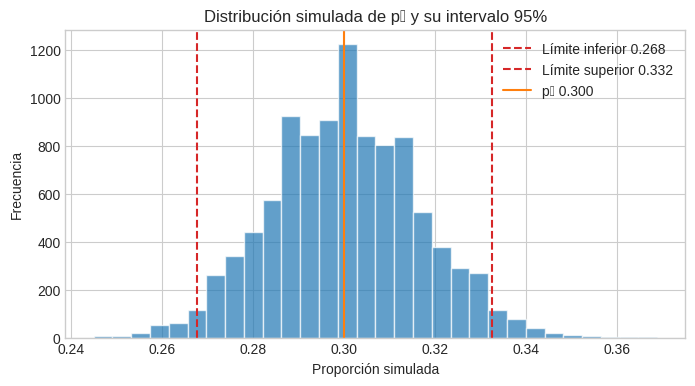

/tmp/ipython-input-1522174001.py:28: UserWarning: Glyph 770 (\N{COMBINING CIRCUMFLEX ACCENT}) missing from font(s) Liberation Sans.
  plt.tight_layout()


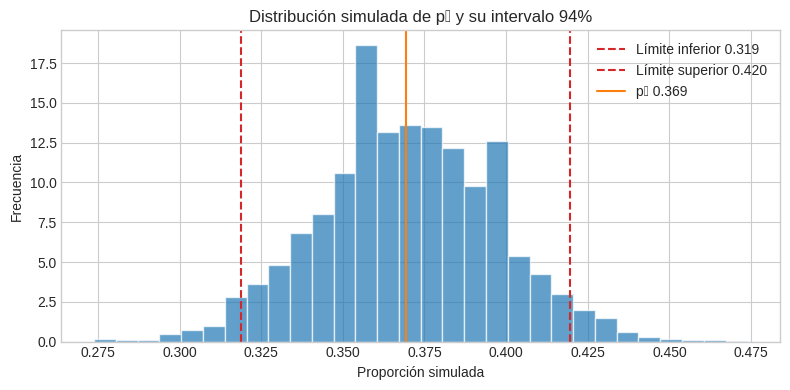

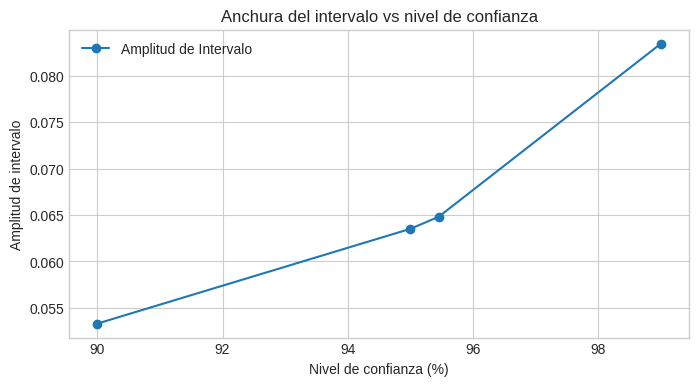

In [51]:
# Visualizamos la distribución simulada de p_hat y su intervalo de confianza
num_simulaciones = 10000
simulaciones = np.random.binomial(n2, res2["p_hat"], size=num_simulaciones) / n2

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(simulaciones, bins=30, color="tab:blue", alpha=0.7, edgecolor="white")
ax.axvline(res2["lower"], color="tab:red", linestyle="--", label=f"Límite inferior {res2['lower']:.3f}")
ax.axvline(res2["upper"], color="tab:red", linestyle="--", label=f"Límite superior {res2['upper']:.3f}")
ax.axvline(res2["p_hat"], color="tab:orange", linestyle="-", label=f"p̂ {res2['p_hat']:.3f}")
ax.set_title(f"Distribución simulada de p̂ y su intervalo {int(res2['confidence']*100)}%")
ax.set_xlabel("Proporción simulada")
ax.set_ylabel("Frecuencia")
ax.legend()
plt.show()

num_simulaciones = 10000
simulaciones = np.random.binomial(n1, res1["p_hat"], size=num_simulaciones) / n1

fig1, ax1 = plt.subplots(figsize=(8, 4))
ax1.hist(simulaciones, bins=30, color="tab:blue", alpha=0.7, edgecolor="white", density=True)
ax1.axvline(res1["lower"], color="tab:red", linestyle="--", label=f"Límite inferior {res1['lower']:.3f}")
ax1.axvline(res1["upper"], color="tab:red", linestyle="--", label=f"Límite superior {res1['upper']:.3f}")
ax1.axvline(res1["p_hat"], color="tab:orange", linestyle="-", label=f"p̂ {res1['p_hat']:.3f}")
ax1.set_title(f"Distribución simulada de p̂ y su intervalo {int(res1['confidence']*100)}%")
ax1.set_xlabel("Proporción simulada")
ax1.set_ylabel("Frecuencia")
ax1.legend()
plt.tight_layout()
plt.show()


conf_levels = np.array([0.90, 0.95, 0.9545, 0.99])
n_problema2 = 800
x_problema2 = 240

amplitudes = []
for conf in conf_levels:
    res = intervalo_proporcion_normal(x_problema2, n_problema2, conf)
    amplitud = res['upper'] - res['lower']
    amplitudes.append(amplitud)

df_amplitud = pd.DataFrame({
    'Nivel de confianza (%)': conf_levels * 100,
    'Amplitud de intervalo': amplitudes
})

#Crear el gráfico de líneas
plt.figure(figsize=(8, 4))
plt.plot(df_amplitud['Nivel de confianza (%)'], df_amplitud['Amplitud de intervalo'], marker='o', linestyle='-', markersize=6, label='Amplitud de Intervalo')

plt.title('Anchura del intervalo vs nivel de confianza')
plt.xlabel('Nivel de confianza (%)')
plt.ylabel('Amplitud de intervalo')
plt.grid(True)
plt.legend()
plt.show()

## Problema 3: Intervalo, error máximo y tamaño muestral requerido

En un control de calidad se analizó una muestra aleatoria de 750 tornillos, resultando defectuosos 80 de ellos.

a) Hallar un intervalo de confianza para la proporción de tornillos defectuosos en el conjunto de producción con 99% de confianza.

b) ¿Cuál es el error máximo cometido en la estimación anterior?

c) Si deseamos que el error cometido, con el mismo nivel de confianza, sea la décima parte del apartado anterior, ¿cuál ha de ser el tamaño de la muestra?

Evaluamos la proporción de tornillos defectuosos, estimamos el error máximo asociado y determinamos el tamaño muestral necesario si buscamos reducir dicho error en un factor de diez manteniendo el 99% de confianza.

In [52]:
# Definimos el tamaño de la muestra, el número de éxitos y el nivel de confianza para el problema 3
n3 = 750         # tamaño de la muestra
x3 = 80          # número de tornillos defectuosos
conf3 = 0.99     # nivel de confianza (99%)

p_hat3 = x3 / n3

npq3 = n3 * p_hat3 * (1 - p_hat3)
condicion_normal_3 = npq3 >= 10

# Calculamos el intervalo de confianza (a)
res3 = intervalo_proporcion_normal(x3, n3, conf3)
cp3 = intervalo_proporcion_clopper_pearson(x3, n3, conf3)

# (b) ¿Cuál es el error máximo cometido en la estimación anterior?
error_actual = res3["error"]

# (c) Si deseamos que el error cometido, con el mismo nivel de confianza, sea la décima parte del apartado anterior, ¿cuál ha de ser el tamaño de la muestra?
error_objetivo = error_actual / 10

# Calculamos el tamaño de muestra requerido usando la fórmula directa
# Z-score para el nivel de confianza de res3 (conf3)
# Se asume que res3['z'] ya tiene el valor crítico z para conf3
n_requerido = int(np.ceil(res3["p_hat"] * (1 - res3["p_hat"]) * (res3["z"] / error_objetivo) ** 2))

# Con statsmodels para verificar
n_requerido_sm = samplesize_confint_proportion(
    proportion=res3["p_hat"],           # proporción muestral
    half_length=error_objetivo,   # error máximo deseado
    alpha=1 - res3["confidence"], # nivel de significancia 1 - conf3
    method='normal'               # método normal aproximado
)
n_requerido_sm = int(np.ceil(n_requerido_sm))
print("Tamaño muestra mínimo requerido (fórmula manual):", n_requerido)
print("Tamaño muestra mínimo requerido (statsmodels):", n_requerido_sm)

diagnostico3 = pd.DataFrame({
    "parametro": ["n", "x", "p_hat", "n*p_hat*(1-p_hat)", "condicion_normal"],
    "valor": [n3, x3, p_hat3, npq3, condicion_normal_3]
})

resumen3 = resumen_intervalo("Tornillos defectuosos (99%)", res3, cp3)

dimensionamiento = pd.DataFrame({
    "escenario": ["Error actual", "Error objetivo", "Tamaño muestral requerido (manual)", "Tamaño muestral requerido (statsmodels)"],
    "valor": [error_actual, error_objetivo, n_requerido, n_requerido_sm]
})

display(diagnostico3)
display(resumen3)
display(dimensionamiento)

Tamaño muestra mínimo requerido (fórmula manual): 75000
Tamaño muestra mínimo requerido (statsmodels): 75000


,parametro,valor
0,n,750
1,x,80
2,p_hat,0.106667
3,n*p_hat*(1-p_hat),71.466667
4,condicion_normal,True


,escenario,muestra (x/n),p_con_hat,nivel_confianza,limite_inferior,limite_superior,error_maximo,cp_inferior,cp_superior
0,Tornillos defectuosos (99%),80/750,0.106667,0.99,0.077633,0.135701,0.029034,0.079548,0.138913


,escenario,valor
0,Error actual,0.029034
1,Error objetivo,0.002903
2,Tamaño muestral requerido (manual),75000.000000
3,Tamaño muestral requerido (statsmodels),75000.000000


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 770 (\N{COMBINING CIRCUMFLEX ACCENT}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


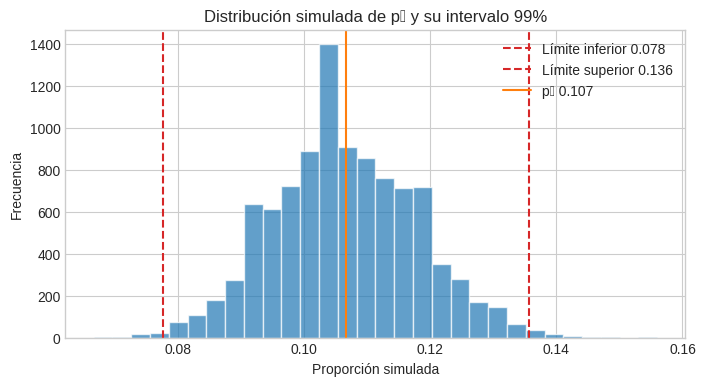

/tmp/ipython-input-3146225754.py:28: UserWarning: Glyph 770 (\N{COMBINING CIRCUMFLEX ACCENT}) missing from font(s) Liberation Sans.
  plt.tight_layout()


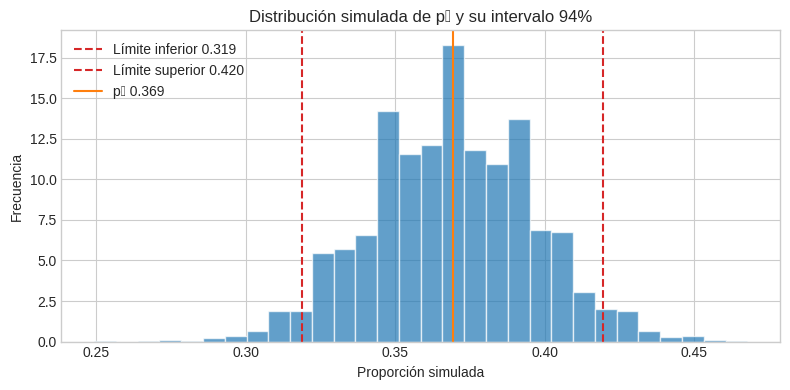

In [75]:
# Visualizamos la distribución simulada de p_hat y su intervalo de confianza
num_simulaciones = 10000
simulaciones = np.random.binomial(n3, p_hat3, size=num_simulaciones) / n3

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(simulaciones, bins=30, color="tab:blue", alpha=0.7, edgecolor="white")
ax.axvline(res3["lower"], color="tab:red", linestyle="--", label=f"Límite inferior {res3['lower']:.3f}")
ax.axvline(res3["upper"], color="tab:red", linestyle="--", label=f"Límite superior {res3['upper']:.3f}")
ax.axvline(res3["p_hat"], color="tab:orange", linestyle="-", label=f"p̂ {res3['p_hat']:.3f}")
ax.set_title(f"Distribución simulada de p̂ y su intervalo {int(res3['confidence']*100)}%")
ax.set_xlabel("Proporción simulada")
ax.set_ylabel("Frecuencia")
ax.legend()
plt.show()


simulaciones = np.random.binomial(n1, p_hat1, size=num_simulaciones) / n1

fig1, ax1 = plt.subplots(figsize=(8, 4))
ax1.hist(simulaciones, bins=30, color="tab:blue", alpha=0.7, edgecolor="white", density=True)
ax1.axvline(res1["lower"], color="tab:red", linestyle="--", label=f"Límite inferior {res1['lower']:.3f}")
ax1.axvline(res1["upper"], color="tab:red", linestyle="--", label=f"Límite superior {res1['upper']:.3f}")
ax1.axvline(res1["p_hat"], color="tab:orange", linestyle="-", label=f"p̂ {res1['p_hat']:.3f}")
ax1.set_title(f"Distribución simulada de p̂ y su intervalo {int(res1['confidence']*100)}%")
ax1.set_xlabel("Proporción simulada")
ax1.set_ylabel("Frecuencia")
ax1.legend()
plt.tight_layout()
plt.show()